
# Exploratory Data Analysis (SSTA, PLymouth Coastal Box)

**Project:** Sea Surface Temperature Anomaly Forecasting (SSTA)  


## Learning goals
- Verify data integrity and time coverage.
- Visualize anomaly evolution over time (trend & variability).
- Examine seasonal structure (monthly subseries) and distributional properties.
- Decompose the series with STL (trend / seasonality / remainder).
- Inspect basic autocorrelation (ACF/PACF) to inform model choices.



##  Setup & configuration
  
:

```
data/processed/ssta_<project>_monthly.parquet
```



In [ ]:

# --- Configuration ---
PROJECT = "ssta_plymouth"          
PROCESSED_DIR = "../data/processed"


import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
from statsmodels.tsa.seasonal import STL # type: ignore
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # type: ignore

# Helper to detect SSTA file
def detect_ssta_path(processed_dir: str, project: str) -> Path:
    candidates = [
        Path(processed_dir) / f"ssta_{project}_monthly.parquet",
        Path(processed_dir) / f"ssta_{project}_monthly.csv",
        Path(processed_dir) / f"ssta_ssta_{project}_monthly.parquet",
        Path(processed_dir) / f"ssta_ssta_{project}_monthly.csv",
    ]
    for p in candidates:
        if p.exists():
            return p
    
    matches = sorted(Path(processed_dir).glob("ssta_*_monthly.*"))
    if not matches:
        raise FileNotFoundError(f"Could not find SSTA file in {processed_dir}. "
                                f"Checked: {[str(c) for c in candidates]}" )
    return matches[-1]



## 1. Load SSTA series



In [6]:

ssta_path = detect_ssta_path(PROCESSED_DIR, PROJECT)
print(f"Using SSTA file: {ssta_path}")

ext = ssta_path.suffix.lower()
if ext == ".parquet":
    df = pd.read_parquet(ssta_path)
else:
    df = pd.read_csv(ssta_path)

# Normalize columns
df = df.rename(columns={c: c.lower() for c in df.columns})
if "date" not in df.columns:
    for c in df.columns:
        if "date" in c:
            df = df.rename(columns={c: "date"})
            break
if "ssta" not in df.columns:
    for c in df.columns:
        if str(c).lower().startswith("ssta"):
            df = df.rename(columns={c: "ssta"})
            break

df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)
df["date"] = df["date"].dt.to_period("M").dt.to_timestamp()
df["ssta"] = pd.to_numeric(df["ssta"], errors="coerce").astype("float32")
print(df.head())
print(df.tail())
print(df.describe(include='all'))
print(f"Rows: {len(df)}   Range: {df['date'].min().date()} → {df['date'].max().date()}")

Using SSTA file: ../data/processed/ssta_ssta_plymouth_monthly.parquet
        date      ssta
0 1982-01-01 -1.337977
1 1982-02-01 -0.859627
2 1982-03-01 -0.504851
3 1982-04-01 -0.248244
4 1982-05-01 -0.275887
          date      ssta
519 2025-04-01  1.226422
520 2025-05-01  1.770618
521 2025-06-01  1.522754
522 2025-07-01  1.664122
523 2025-08-01  0.765837
                                date        ssta
count                            524  524.000000
mean   2003-10-16 13:55:25.190839680   -0.034861
min              1982-01-01 00:00:00   -2.232351
25%              1992-11-23 12:00:00   -0.504476
50%              2003-10-16 12:00:00    0.001124
75%              2014-09-08 12:00:00    0.462098
max              2025-08-01 00:00:00    1.770618
std                              NaN    0.697130
Rows: 524   Range: 1982-01-01 → 2025-08-01



## 2. Data quality checks
Basic completeness and missing values inspection.


In [7]:

# Missing values by column
print(df.isna().sum())

# Check for duplicate months
dup_months = df["date"].duplicated().sum()
print(f"Duplicate months: {dup_months}")


date    0
ssta    0
dtype: int64
Duplicate months: 0



## 3. Time series view
A simple line plot of monthly SSTA.  



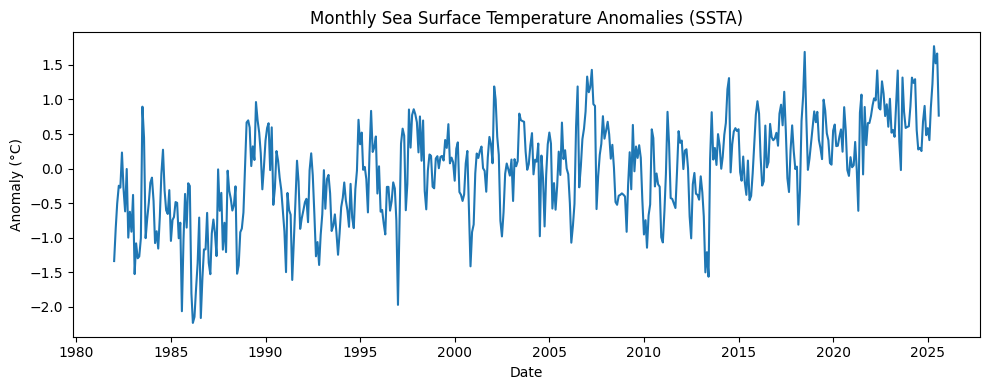

In [13]:

plt.figure(figsize=(10,4))
plt.plot(df["date"], df["ssta"])
plt.title("Monthly Sea Surface Temperature Anomalies (SSTA)")
plt.xlabel("Date")
plt.ylabel("Anomaly (°C)")
plt.tight_layout()
plt.show()


**Interpretation tip:** upward trend


## 4. Distributional view



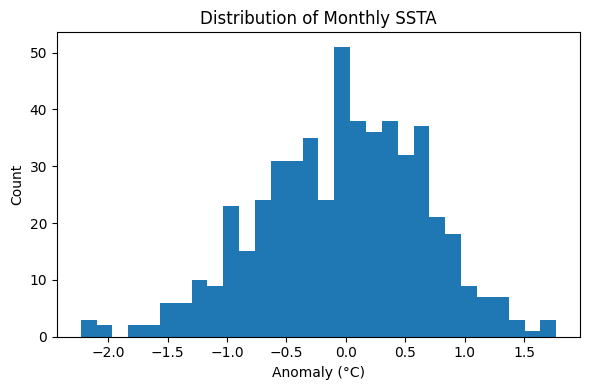

In [14]:

plt.figure(figsize=(6,4))
plt.hist(df["ssta"].dropna().values, bins=30)
plt.title("Distribution of Monthly SSTA")
plt.xlabel("Anomaly (°C)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()



## 5. Seasonal structure (monthly subseries)
Plot monthly anomaly distributions to see the seasonal pattern.


<Figure size 900x400 with 0 Axes>

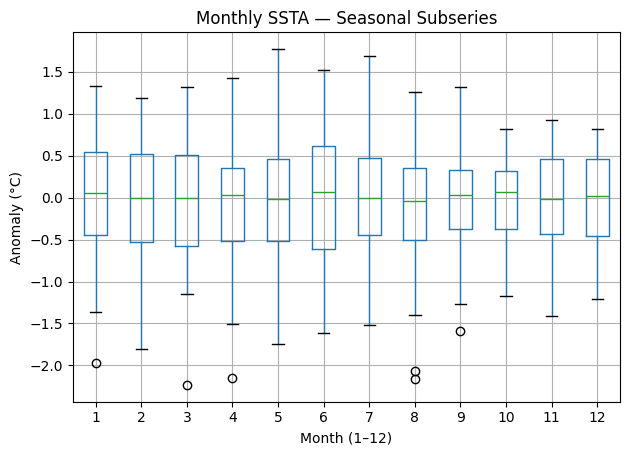

In [15]:

tmp = df.copy()
tmp["month"] = tmp["date"].dt.month

# Boxplot by month
plt.figure(figsize=(9,4))
tmp.boxplot(column="ssta", by="month")
plt.suptitle("")
plt.title("Monthly SSTA — Seasonal Subseries")
plt.xlabel("Month (1–12)")
plt.ylabel("Anomaly (°C)")
plt.tight_layout()
plt.show()



## 6. STL decomposition (trend/season/residual)

Decompose the series with **STL** (Seasonal and Trend decomposition using Loess) using a seasonal period of 12 (monthly data).


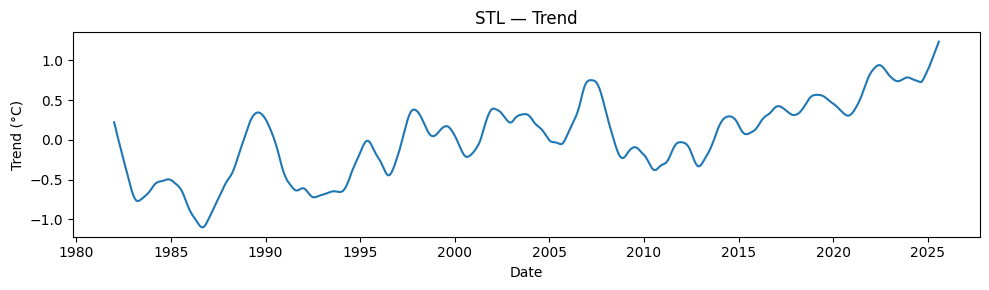

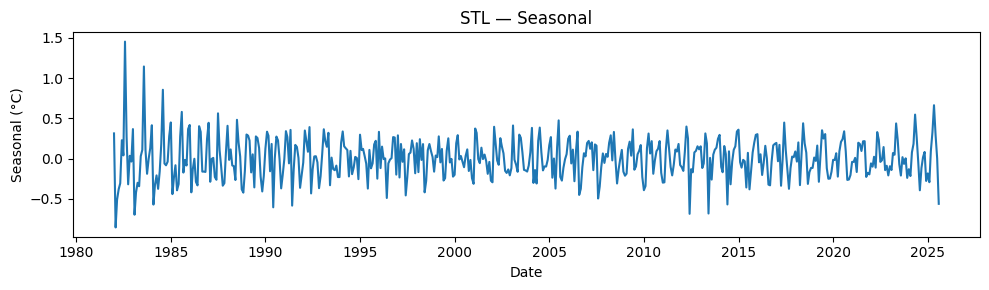

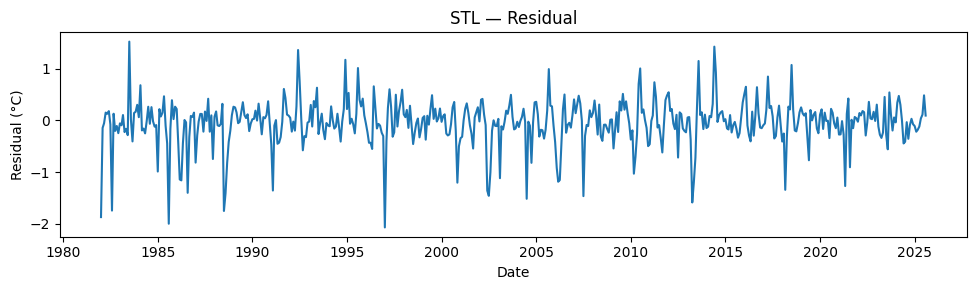

In [16]:

y = df["ssta"].astype(float).values
stl = STL(y, period=12, robust=True)
res = stl.fit()
trend = res.trend
seasonal = res.seasonal
resid = res.resid

# Plot each component in its own figure
plt.figure(figsize=(10,3))
plt.plot(df["date"], trend)
plt.title("STL — Trend")
plt.xlabel("Date"); plt.ylabel("Trend (°C)")
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,3))
plt.plot(df["date"], seasonal)
plt.title("STL — Seasonal")
plt.xlabel("Date"); plt.ylabel("Seasonal (°C)")
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,3))
plt.plot(df["date"], resid)
plt.title("STL — Residual")
plt.xlabel("Date"); plt.ylabel("Residual (°C)")
plt.tight_layout(); plt.show()



## 7. Autocorrelation (ACF/PACF)

We inspect autocorrelation to inform SARIMA or lag choices, The plots below help assess seasonal lags (e.g., at 12 months).


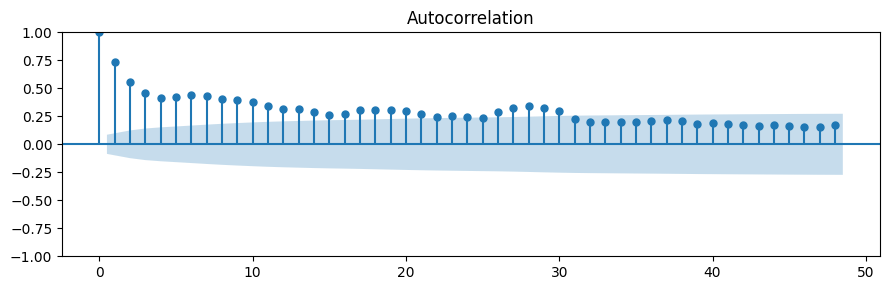

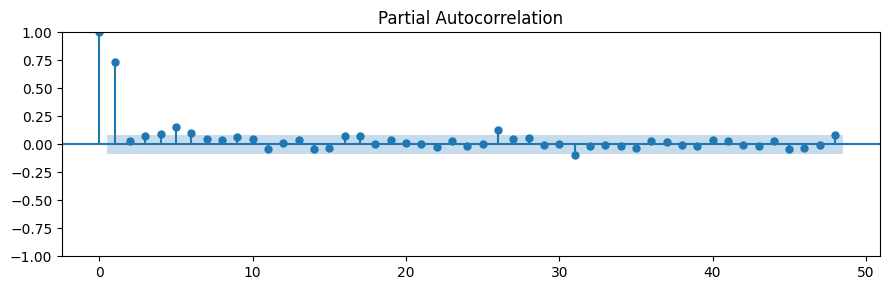

In [17]:

# ACF
fig = plt.figure(figsize=(9,3))
plot_acf(df["ssta"].astype(float), lags=48, ax=plt.gca())
plt.tight_layout(); plt.show()

# PACF
fig = plt.figure(figsize=(9,3))
plot_pacf(df["ssta"].astype(float), lags=48, method="ywm", ax=plt.gca())
plt.tight_layout(); plt.show()
